In [1]:
import pandas as pd
import numpy as np

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [3]:
!wget $data

--2026-01-11 09:10:34--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv.1’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.002s  

2026-01-11 09:10:35 (33.2 MB/s) - ‘course_lead_scoring.csv.1’ saved [80876/80876]



In [4]:
#turn dataset into a pandas dataframe
df = pd.read_csv(data)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [5]:
#check for missing values or nulls
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
#get object type columns
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
string_columns

#get numerical columns
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [7]:
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    df[col] = df[col].str.replace('-','_')

In [8]:
#replace missing feilds with NA for categorical columns
df[string_columns] = df[string_columns].fillna('NA')
df[string_columns]

,lead_source,industry,employment_status,location
0,paid_ads,NA,unemployed,south_america
1,social_media,retail,employed,south_america
2,events,healthcare,unemployed,australia
3,paid_ads,retail,NA,australia
4,referral,education,self_employed,europe
...,...,...,...,...
1457,referral,manufacturing,self_employed,north_america
1458,referral,technology,student,europe
1459,paid_ads,technology,student,north_america
1460,referral,NA,self_employed,north_america


In [9]:
#replace missing feilds with 0.0 for numerical columns
df['annual_income'] = df['annual_income'].fillna(0.0)
df['annual_income']

0       79450.0
1       46992.0
2       78796.0
3       83843.0
4       85012.0
         ...   
1457        0.0
1458    65259.0
1459    45688.0
1460    71016.0
1461    92855.0
Name: annual_income, Length: 1462, dtype: float64

In [10]:
df.head(20)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
5,events,manufacturing,1,59904.0,NA,africa,6,0.83,1
6,social_media,technology,0,51283.0,NA,middle_east,2,0.57,0
7,social_media,NA,5,62975.0,student,europe,4,0.62,1
8,referral,healthcare,4,38648.0,unemployed,south_america,2,0.86,1
9,paid_ads,other,3,59866.0,student,australia,3,0.43,1


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [12]:
#split into training, testing and validation dataset
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

#get testing and validation column
y_train = df_train.converted.values
y_val = df_val.converted.values

#delete conversion column
del df_train['converted']
del df_val['converted']

In [13]:
len(df_train), len(df_val), len(df_test), len(df_train_full), len(df)

(876, 293, 293, 1169, 1462)

In [14]:
# 3) Compute univariate ROC AUC per feature
auc_per_feature = {}
for col in numerical:
    # Use the feature values as scores (no model) — good for monotonic relations
    scores = df_train[col].values
    # If a feature is constant in test set, skip to avoid errors
    if np.all(scores == scores[0]):
        continue
    auc = roc_auc_score(y_train, scores)
    auc_per_feature[col] = auc


# 4) Rank features
feature_auc = pd.Series(auc_per_feature).sort_values(ascending=False)
feature_auc



number_of_courses_viewed    0.763568
interaction_count           0.738270
lead_score                  0.614499
annual_income               0.551958
dtype: float64

The numerical variable with the highest AUC is number_of_courses_viewed

In [15]:
#one hot encoding for categorical varialbles
df_train_dict = df_train.to_dict(orient='records')

#create an instance of dictvectorizer
dv = DictVectorizer(sparse=False)

#fitting and transforming training dataset
One_hot_df_train = dv.fit_transform(df_train_dict)
One_hot_df_train

array([[9.5543e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        2.0000e+00],
       [5.4924e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        1.0000e+00],
       [7.7352e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        2.0000e+00],
       ...,
       [7.3702e+04, 0.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        1.0000e+00],
       [9.3341e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]], shape=(876, 31))

In [16]:
#using logistic regression model to train dataset
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(One_hot_df_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [17]:
#doing same for validation dataset
df_val_dict = df_val.to_dict(orient='records')
One_hot_df_val = dv.transform(df_val_dict)
One_hot_df_val

array([[0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [5.8777e+04, 1.0000e+00, 0.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        2.0000e+00],
       [7.8148e+04, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        3.0000e+00],
       ...,
       [9.2215e+04, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        4.0000e+00],
       [5.3087e+04, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        2.0000e+00],
       [6.0375e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        3.0000e+00]], shape=(293, 31))

In [18]:
#getting the prediction
y_pred = model.predict_proba(One_hot_df_val)[:, 1]

In [19]:
#getting the true prediction
converted_decision = (y_pred >= 0.5)

In [20]:
#getting the accuracy
(y_val == converted_decision).mean()

np.float64(0.6996587030716723)

In [21]:
from sklearn.metrics import accuracy_score

In [22]:
accuracy_score(y_val, y_pred >= 0.5)

0.6996587030716723

In [23]:
#confusion table
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

In [24]:
#getting the AUC
auc = roc_auc_score(y_val, y_pred)
auc

0.8171316268814112

In [25]:
#presicion and recall
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall

(np.float64(0.6693877551020408), np.float64(0.9590643274853801))

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

In [27]:
#run the loop
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_predict = (y_pred >= t).astype(int)
    precisions.append(precision_score(y_val, y_predict, zero_division=0))
    recalls.append(recall_score(y_val, y_predict))


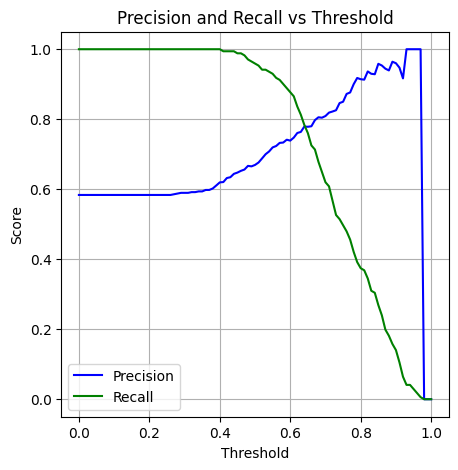

In [28]:

plt.figure(figsize=(5, 5))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


The treshold at whcih precision and recall curves intersect is 0.745

In [29]:
#computing F1 score
from sklearn.metrics import f1_score

In [30]:

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_predict = (y_pred >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_predict, zero_division=0))


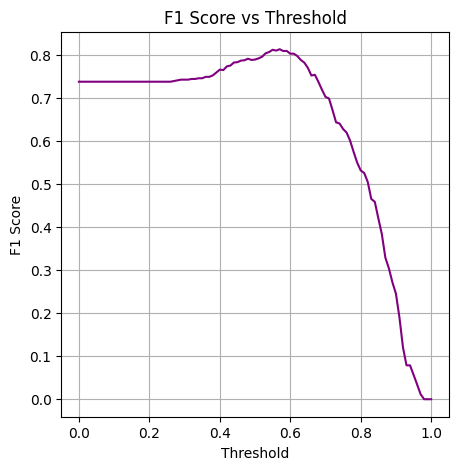

In [31]:

plt.figure(figsize=(5, 5))
plt.plot(thresholds, f1_scores, color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True)
plt.show()


The threshold at which F1 score is maximal is 0.54

In [32]:
df[string_columns + numerical]

,lead_source,industry,employment_status,location,number_of_courses_viewed,annual_income,interaction_count,lead_score
0,paid_ads,NA,unemployed,south_america,1,79450.0,4,0.94
1,social_media,retail,employed,south_america,1,46992.0,1,0.80
2,events,healthcare,unemployed,australia,5,78796.0,3,0.69
3,paid_ads,retail,NA,australia,2,83843.0,1,0.87
4,referral,education,self_employed,europe,3,85012.0,3,0.62
...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,self_employed,north_america,1,0.0,4,0.53
1458,referral,technology,student,europe,3,65259.0,2,0.24
1459,paid_ads,technology,student,north_america,1,45688.0,3,0.02
1460,referral,NA,self_employed,north_america,5,71016.0,0,0.25


In [33]:
#kFold
def train(df, y):
    cat = df[string_columns + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[string_columns + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [34]:
from sklearn.model_selection import KFold

In [35]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [36]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.converted.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [37]:
np.array(aucs).round(3)

array([0.806, 0.871, 0.775, 0.802, 0.856])

In [38]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.822 ± 0.036


In [39]:
#tuning the parameter C
def train(df, y, C=1.0):
    cat = df[string_columns + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [40]:
nfolds = 5
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=1e-06, auc = 0.560 ± 0.024
C=0.001, auc = 0.867 ± 0.029
C=1, auc = 0.822 ± 0.036


The C with the best mean score is 0.001